## Proximal Policy Optimization (PPO) ##

Основные характеристики:

- Model-free
- Actor-Critic(Актор - реализует политику, т.е выбирает действие. Критик - оценивает действия)
- On-policy


<img src="images/sensors-20-01359-g003.png" alt="image" width="70%" height="auto">

Чтобы избежать резких изменений стратегии вводится:

$r(\theta) = \frac{\pi_{\theta} (a | s)}{\pi_{\theta_{old}} (a | s)}$

это показывает насколько изменилась вероятность выбора конкретного действия после обновления параметров. Если $r(\theta)$ сильно отклоняется от 1, значит, новая политика слишком отличается от старой, и это может быть опасно для стабильности обучения

$\hat{A}$ - оценка преимущества действия

$L^{CLIP} = \mathbb{E}[min(r_t(\theta) A_t, clip(r_t(\theta) A_t, 1 - \epsilon, 1 + \epsilon))]$, где

$\quad \epsilon$ - гиперпараметр для "обрезки"(обычно 0.1-0.3)

Итоговый loss:

$L^{PPO}(\theta) = L^{CLIP}(\theta) + c_1 L^{VF}(\theta) - c_2 S[\pi_{\theta}](s_t)$

- $L^{VF}(\theta)$ - loss для критика(value function)
- $S[\pi_{\theta}](s_t)$ - энтропия, отвечает за exploraion

__Note__:

В SB3 используется оптимизатор `ADAM`, вместо `SGD`

In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# 1. Создание среды и оберток
env = gym.make("CartPole-v1") # 
env = Monitor(env, "./logs/")  # Логирование статистики
env = DummyVecEnv([lambda: env])  # Векторизация для ускорения


In [3]:
# 2. Гиперпараметры PPO
config = {
    "policy": "MlpPolicy",
    "learning_rate": 3e-4,
    "n_steps": 2048,          # Число шагов перед обновлением
    "batch_size": 64,         # Размер батча для обучения
    "n_epochs": 10,           # Число эпох на один набор данных
    "gamma": 0.99,            # Коэффициент дисконтирования
    "gae_lambda": 0.95,       # Параметр для GAE
    "ent_coef": 0.01,         # Коэффициент энтропии
    "verbose": 1              # Вывод логов
}

In [4]:
# 3. Инициализация модели PPO
model = PPO(
    policy=config["policy"],
    env=env,
    learning_rate=config["learning_rate"],
    n_steps=config["n_steps"],
    batch_size=config["batch_size"],
    n_epochs=config["n_epochs"],
    gamma=config["gamma"],
    gae_lambda=config["gae_lambda"],
    ent_coef=config["ent_coef"],
    verbose=config["verbose"]
)

Using cpu device


In [5]:
# 4. Callbacks для оценки и сохранения модели
eval_callback = EvalCallback(
    env,
    best_model_save_path="./best_model/",
    log_path="./logs/",
    eval_freq=5000,           # Частота оценки (в шагах)
    deterministic=True
)

In [6]:
# 5. Обучение модели
total_timesteps = 3000 # 100_000
model.learn(
    total_timesteps=total_timesteps,
    callback=eval_callback,
    progress_bar=True
)

Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.1     |
|    ep_rew_mean     | 23.1     |
| time/              |          |
|    fps             | 754      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 24.8        |
|    ep_rew_mean          | 24.8        |
| time/                   |             |
|    fps                  | 503         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008925831 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.000682   |
|    learning_rate        | 0.0003      |
|    loss                 | 7.16        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 52.7        |
-----------------------------------------


In [7]:
# 6. Сохранение модели
model.save("./ppo_cartpole")
print("Модель сохранена в ppo_cartpole.zip")

Модель сохранена в ppo_cartpole.zip


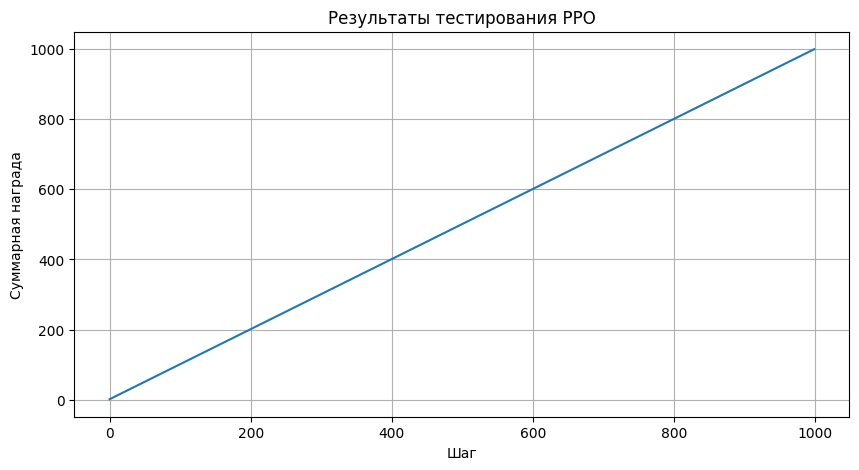

Средняя награда за 1000 шагов: 1.00
Максимальная награда: 1.0
Общее число шагов обучения: 3000


In [9]:
# 7. Загрузка и тестирование лучшей модели
best_model = PPO.load("./best_model/best_model") # "ppo_cartpole.zip"
obs = env.reset()
rewards = []
for _ in range(1000):
    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    if done:
        obs = env.reset()

# 8. Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(rewards))
plt.xlabel("Шаг")
plt.ylabel("Суммарная награда")
plt.title("Результаты тестирования PPO")
plt.grid()
plt.savefig("./ppo_performance.png")
plt.show()

# 9. Вывод статистики
print(f"Средняя награда за 1000 шагов: {np.mean(rewards):.2f}")
print(f"Максимальная награда: {np.max(rewards)}")
print(f"Общее число шагов обучения: {total_timesteps}")

# 10. Просмотр логов в TensorBoard (запустить в терминале)
# tensorboard --logdir=./logs/

In [9]:
from stable_baselines3.common.vec_env import VecVideoRecorder

# 1. Создаем среду
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = Monitor(env, "./logs/")
env = DummyVecEnv([lambda: env])

# 2. Загружаем обученную модель (или обучаем с нуля)
model = PPO.load("ppo_cartpole.zip")  # Путь к вашей модели

# 3. Настройки записи видео
video_length = 1000  # Длина видео в шагах
video_folder = "./videos/"
video_name = "ppo_cartpole_video"

# 4. Обертка для записи видео
env = VecVideoRecorder(
    env,
    video_folder,
    record_video_trigger=lambda x: x == 0,  # Запись сразу
    video_length=video_length,
    name_prefix=video_name
)

# 5. Запуск агента и запись
obs = env.reset()
for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, _, _ = env.step(action)

env.close()  # Видео сохранится автоматически

Saving video to c:\Users\Очир\Desktop\Учёба\Машинное обучение\videos\ppo_cartpole_video-step-0-to-step-1000.mp4
MoviePy - Building video c:\Users\Очир\Desktop\Учёба\Машинное обучение\videos\ppo_cartpole_video-step-0-to-step-1000.mp4.
MoviePy - Writing video c:\Users\Очир\Desktop\Учёба\Машинное обучение\videos\ppo_cartpole_video-step-0-to-step-1000.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\Очир\Desktop\Учёба\Машинное обучение\videos\ppo_cartpole_video-step-0-to-step-1000.mp4
